

```
# This is formatted as code
```

# Testing different implementations of SRT

## Packages

In [ ]:
%pylab inline
from collections import Counter, defaultdict
from scipy.stats import bernoulli
from scipy.stats import binom
import numpy as np

import multiprocessing

import torch
import torch.multiprocessing as mp

Populating the interactive namespace from numpy and matplotlib


##Sample Randomize and Threshold (SRT)

### Algorithm


#### SRT v1

In [ ]:
#Estimation of SRT with correction

def SRT_v1(X, B, t0, t1, ps, tau):
    n = len(X)
    elements = []
    for el in range(1, B+1):
        elements.append(el)

    #Calculating true count
    cx = Counter(X)

    #Calculating true relative frequency
    phix = defaultdict(int)
    for k in cx.keys():
        phix[k] = cx[k] / n

    #Randomization
    X_rand = []
    for x in X:
        ex = [0] * (B+1)
        ex[x] = 1
        for i in range(1, len(ex)):
            if ex[i] == 1:
                ex[i] = bernoulli.rvs(t1)
            else:
                ex[i] = bernoulli.rvs(t0)
        for i in range(len(ex)):
            if ex[i] == 1:
                X_rand.append(i)

    #Sampling (the implementation is different)
    sample = []
    for a in X_rand:
        rv = bernoulli.rvs(ps)
        if rv:
            sample.append(a)
    calg = Counter(sample)

    #Thresholding
    for k in calg.keys():
        if calg[k] < tau:
            calg[k] = 0
        # correction
        if calg[k] > 0:
            calg[k] = int ((calg[k] - n * ps * t0) / (ps * (t1-t0)) )

    #Calculating estimated relative frequency (with the total size = total nonzer counts)
    phialg = defaultdict(int)
    total_app = sum(list(calg.values()))
    for k in calg.keys():
        phialg[k] = calg[k] / total_app

    return cx, phix, calg, phialg

#### SRTv2

In [ ]:
import torch
from collections import Counter, defaultdict

def encode_and_randomize(x, B, t0, t1, device):
    # Create tensors directly on the appropriate device
    one_hot_vector = torch.zeros(B+1, device=device)
    one_hot_vector[x] = 1
    encoded_vector = torch.where(one_hot_vector == 0,
                                 torch.bernoulli(torch.full((B+1,), float(t0), device=device)),
                                 torch.bernoulli(torch.full((B+1,), float(t1), device=device)))
    return encoded_vector

def SRT_v2(X, B, t0, t1, ps, tau, device='cuda'):

    n = len(X)

    # Calculating true count
    cx = Counter(X)

    # Calculating true relative frequency
    phix = {k: v / n for k, v in cx.items()}

    matrix2 = torch.empty((n, B+1), device=device)

    for i, x in enumerate(X):
        encoded_vector = encode_and_randomize(x, B, t0, t1, device)
        matrix2[i] = encoded_vector

    matrix1 = torch.bernoulli(torch.full((1, n), ps, device=device))
    result = torch.matmul(matrix1, matrix2)

    X_rand = result.cpu().tolist()
    calg = X_rand[0]

    # Thresholding
    for k in range(len(calg)):
        calg[k] = int((calg[k] - n * ps * t0) / (ps * (t1 - t0)))
        if calg[k] < tau:
            calg[k] = 0

    # Calculating estimated relative frequency (with the total size = total non-zero counts)
    total_app = sum(calg)
    phialg = {k: calg[k] / total_app for k in range(B)}

    return cx, phix, calg, phialg

### Parameter tuning (Randomization mechanism)

In [ ]:
def OUE(eps, delta, n, eps_0, tune_p = False, optional_p = 1):
    t1 = 1/2
    t0 = 1/(np.exp(eps_0 / 2) + 1)

    p = (np.exp(eps) - 1) / (np.exp(eps) * t1 - t0)
    if p > 1:
      p = min(p, 1)
      print("Warning: p > 1, the privacy guarantee eps will be smaller than the assigned.")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )
    if tune_p:
      p = min([p, optional_p])
      print("Warning: p is tuned. ")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )

    q = (1-p*t1) / (1 - p*t0)
    eta = (1 - q**2) - p*t1 + p*t0
    alpha = np.sqrt( np.log(delta) / (-2 * n * p**2 * t0**2))
    tau = ( (1 + alpha) * (1 - q**2) * n * p * t0 / eta - n * t0 ) / (t1 - t0)
    return t1, t0, float(p), tau

In [ ]:
def DE(eps, delta, n, eps_0, B, tune_p = False, optional_p = 1):
    t1 = np.exp(eps_0) / (np.exp(eps_0) + B - 1)
    t0 = 1 / (np.exp(eps_0) + B - 1)

    p = (np.exp(eps) - 1) / (np.exp(eps) * t1 - t0)
    if p > 1:
      p = min(p, 1)
      print("Warning: p > 1, the privacy guarantee eps will be smaller than the assigned.")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )
    if tune_p:
      p = min([p, optional_p])
      print("Warning: p is tuned. ")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )

    q = (1-p*t1) / (1 - p*t0)
    eta = (1 - q**2) - p*t1 + p*t0
    alpha = np.sqrt( np.log(delta) / (-2 * n * p**2 * t0**2))
    tau = (1 + alpha) * (1 - q**2) * n * p * t0 / eta
    return t1, t0, p, tau

In [ ]:
def SYM(eps, delta, n, eps_0, tune_p = False, optional_p = 1):
    t1 = np.exp(eps_0 / 2) / (np.exp(eps_0 / 2) + 1)
    t0 = 1 / (np.exp(eps_0 / 2) + 1)

    p = (np.exp(eps) - 1) / (np.exp(eps) * t1 - t0)
    if p > 1:
      p = min(p, 1)
      print("Warning: p > 1, the privacy guarantee eps will be smaller than the assigned.")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )
    if tune_p:
      p = min([p, optional_p])
      print("Warning: p is tuned. ")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )


    q = (1-p*t1) / (1 - p*t0)
    eta = (1 - q**2) - p*t1 + p*t0
    alpha = np.sqrt( np.log(delta) / (-2 * n * p**2 * t0**2))
    tau = (1 + alpha) * (1 - q**2) * n * p * t0 / eta
    return t1, t0, p, tau

## Sample and Threshold (ST)

###Algorithm

In [ ]:
#Estimation of ST with correction

def ST_sim(X, B, ps, tau):
    n = len(X)

    #counting true frequency
    cx = Counter(X)

    #obtaining true relative frequency
    phix = defaultdict(int)
    for k in cx.keys():
        phix[k] = cx[k] / n

    #sampling
    sample = []
    for a in X:
        rv = bernoulli.rvs(ps)
        if rv:
            sample.append(a)
    calg = Counter(sample)

    calg[k] = int(calg[k] / ps)  # correction
    #tau_corrected = tau / ps
    #thresholding
    for k in calg.keys():
        if calg[k] < tau:
            calg[k] = 0

    #obtaining estimated relative frequency
    phialg = defaultdict(int)
    total_app = sum(list(calg.values()))
    for k in calg.keys():
        phialg[k] = calg[k] / total_app

    return cx, phix, calg, phialg

#cx = true count
#phix = true relative frequency
#calg = estimated count after ST
#phialg = estimated relative frequency

### Parameter Tuning

In [ ]:
def st_param(eps, delta, alpha = 0.2):
    if eps > 1:
      print("Warning of ST: eps is not allowed")
    ps = alpha * (1 - np.exp(-eps))
    Calp = np.log(1/alpha) - 1/(1+alpha)
    if Calp < 0:
      print("Warning of ST: C_alpha < 0")
    tau = 1 / Calp * np.log(1 / delta)
    return ps, tau / ps

##Unary Encoding (UE)

###Algorithm

In [ ]:
#Algorithm of unary encoding

import torch
from collections import Counter, defaultdict

def encode_and_randomize(x, B, t0, t1, device):
    # Create tensors directly on the appropriate device
    one_hot_vector = torch.zeros(B+1, device=device)
    one_hot_vector[x] = 1
    encoded_vector = torch.where(one_hot_vector == 0,
                                 torch.bernoulli(torch.full((B+1,), float(t0), device=device)),
                                 torch.bernoulli(torch.full((B+1,), float(t1), device=device)))
    return encoded_vector

def UE(X, B, t0, t1, ps, tau, device='cuda'):
    n = len(X)

    # Calculating true count
    cx = Counter(X)

    # Calculating true relative frequency
    phix = {k: v / n for k, v in cx.items()}

    matrix2 = torch.empty((n, B+1), device=device)

    for i, x in enumerate(X):
        encoded_vector = encode_and_randomize(x, B, t0, t1, device)
        matrix2[i] = encoded_vector

    matrix1 = torch.bernoulli(torch.full((1, n), 1.0, device=device))
    result = torch.matmul(matrix1, matrix2)

    X_rand = result.cpu().tolist()
    calg = X_rand[0]

    # Thresholding
    for k in range(len(calg)):
        calg[k] = int((calg[k] - n * 1 * t0) / (1 * (t1 - t0)))


    # Calculating estimated relative frequency (with the total size = total non-zero counts)
    total_app = sum(calg)
    phialg = {k: calg[k] / total_app for k in range(B)}

    return cx, phix, calg, phialg

def UE_raw(X, B, t0, t1, ps, tau, device='cuda'):

    n = len(X)

    # Calculating true count
    cx = Counter(X)

    # Calculating true relative frequency
    phix = {k: v / n for k, v in cx.items()}

    matrix2 = torch.empty((n, B+1), device=device)

    for i, x in enumerate(X):
        encoded_vector = encode_and_randomize(x, B, t0, t1, device)
        matrix2[i] = encoded_vector

    matrix1 = torch.bernoulli(torch.full((1, n), 1.0, device=device))
    result = torch.matmul(matrix1, matrix2)

    X_rand = result.cpu().tolist()
    calg = X_rand[0]


    # Calculating estimated relative frequency (with the total size = total non-zero counts)
    total_app = sum(calg)
    phialg = {k: calg[k] / total_app for k in range(B)}

    return cx, phix, calg, phialg

###Parameter Tuning

In [ ]:
#Parameter Tuning of Unary Encoding

def ue_param(eps):
  t1 = 1/2
  t0 = 1/(np.exp(eps)+1)
  return t1, t0

## Exp. $B = 2^{8}$.

### Implementation

In [ ]:
#Comparing top k elements
#Index 0 is ST
#Index 1 is UE
#Index 2 is SRT

Eps = [0.1, 0.5, 1]
#Eps = [ 1 ]
Trials = 40

k = 5

delta = 1e-6
B = 2**8
n = 10**5

#storing data
Dataset = []

#define max errors
Err0_max = []
Err1_max = []
Err2_max = []

#define min errors
Err0_avg = []
Err1_avg = []
Err2_avg = []

#Checking GPU
if torch.cuda.is_available():
    device = "cuda"
    print("GPU is available")
else:
    device = "cpu"
    print("GPU is unavailable")

for epsilon in Eps:

  #Tuning ST parameters
  p_st, tau_st = st_param(epsilon, delta, alpha = 1/6)
  print( f"ST parameters: p = {p_st}, tau = {tau_st}" )

  #Tuning UE parameters
  t1_ue, t0_ue = ue_param(epsilon)
  print( f"UE parameters: t1 = {t1_ue}, t0 = {t0_ue}" )

  #Tuning SRT parameters
  eps_0 = 10
  optional_p = 0.5
  t1, t0, p_srt, tau_srt = OUE(epsilon, delta, n, eps_0)
  print( f"SRT parameters: t1 = {t1}, t0 = {t0}, p_srt = {p_srt}, tau = {tau_srt}" )
  if p_srt == 1.0:
    print( f"Warning: tighter epsilon guarantee of SRT at epsilon = {epsilon}" )

  #define max errors
  Err0_max_temp = []
  Err1_max_temp = []
  Err2_max_temp = []

  #define min errors
  Err0_avg_temp = []
  Err1_avg_temp = []
  Err2_avg_temp = []

  for trials in range(Trials):

      #Creating random binomial samples
      X = binom.rvs(n = B, p=0.4, size=n)

      #Implementing ST
      cx0, phix0, calg0, phialg0 = SRT_v2( X, B, 0.0, 1.0, p_st, tau_st, device )
      print("ST works")

      #Implementing UE
      cx1, phix1, calg1, phialg1 = UE( X, B, t0_ue, t1_ue, 1.0, 0.0, device )
      print("UE works")

      #Implementing SRT
      cx2, phix2, calg2, phialg2 = SRT_v2( X, B, t0, t1, p_srt, tau_srt, device )
      print("SRT works")

      if trials == 0:
        for i in range(B):
          if cx0[i] != cx2[i]:
            print("Error: real data does not match.")

      #storing data
      Dataset.append( [cx0, calg0, calg1, calg2] )

      #Measuring errors
      err0 = []
      err1 = []
      err2 = []
      k_frequent = cx0.most_common(k)

      for i in range(len(k_frequent)):
          entry = k_frequent[i][0]
          err0.append( abs( cx0[entry] - calg0[entry] ) / n )
          err1.append( abs( cx0[entry] - calg1[entry] ) / n )
          err2.append( abs( cx0[entry] - calg2[entry] ) / n )

      if len(err0) == 0:
          err0.append(0)
      if len(err1) == 0:
          err1.append(0)
      if len(err2) == 0:
          err2.append(0)

      Err0_max_temp.append(max(err0))
      Err1_max_temp.append(max(err1))
      Err2_max_temp.append(max(err2))

      Err0_avg_temp.append(mean(err0))
      Err1_avg_temp.append(mean(err1))
      Err2_avg_temp.append(mean(err2))

      #print("checkpoint: trials =  ", trials)

  Err0_max.append( mean(Err0_max_temp) )
  Err1_max.append( mean(Err1_max_temp) )
  Err2_max.append( mean(Err2_max_temp) )

  Err0_avg.append( mean(Err0_avg_temp) )
  Err1_avg.append( mean(Err1_avg_temp) )
  Err2_avg.append( mean(Err2_avg_temp) )

  print("checkpoint: epsilon =  ", epsilon)

GPU is available
ST parameters: p = 0.01586043032734008, tau = 932.0055029135224
UE parameters: t1 = 0.5, t0 = 0.47502081252106
SRT parameters: t1 = 0.5, t0 = 0.0066928509242848554, p_srt = 0.19265862279962112, tau = 2734.514927643805


KeyboardInterrupt: 

### Graphics

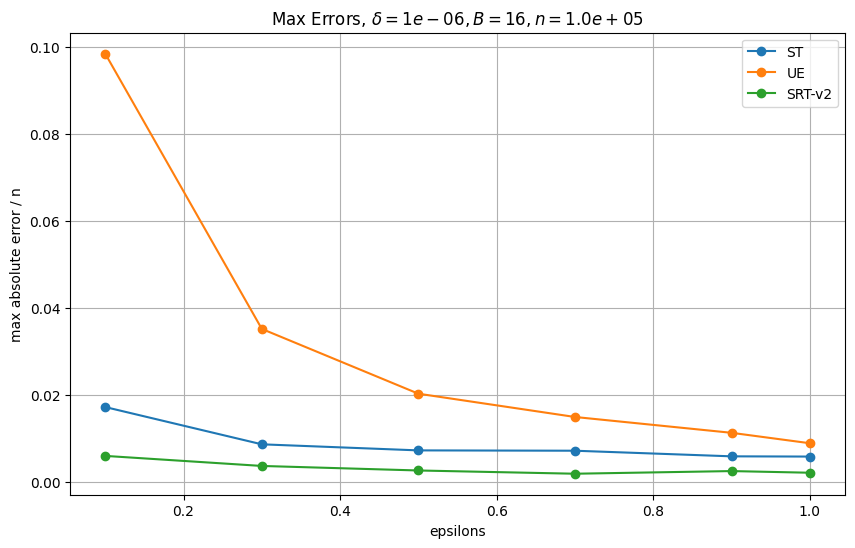

In [ ]:
#Plotting maximum errors

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_max, '-o', label = "ST")
#plt.plot(Eps[:6], Err0_max, '-o', label = "ST")
#plt.plot(range(Trials), Err1_max, '-o', label = "SRT-v1")
plt.plot(Eps, Err1_max, '-o', label = "UE")
plt.plot(Eps, Err2_max, '-o', label = "SRT-v2")
#plt.plot(Eps[:6], Err2_max, '-o', label = "SRT-v2")

plt.title(f"Binomial distribution, B=256")
plt.xlabel('epsilons')
plt.ylabel('Max Error')
plt.grid(True)
plt.legend()
plt.show()

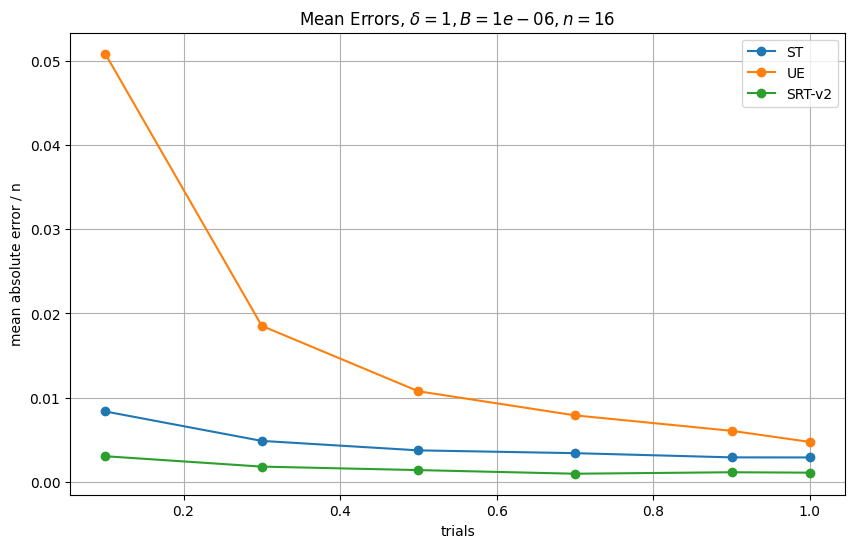

In [ ]:
#Plotting average errors

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_avg, '-o', label = "ST")
plt.plot(Eps, Err1_avg, '-o', label = "UE")
#plt.plot(range(Trials), Err1_avg, '-o', label = "SRT-v1")
plt.plot(Eps, Err2_avg, '-o', label = "SRT-v2")

plt.title(f"Binomial distribution, B=256")
plt.xlabel('epsilons')
plt.ylabel('Avg Error')
plt.grid(True)
plt.legend()
plt.show()

## Graphing binomial distribution

####Graphing

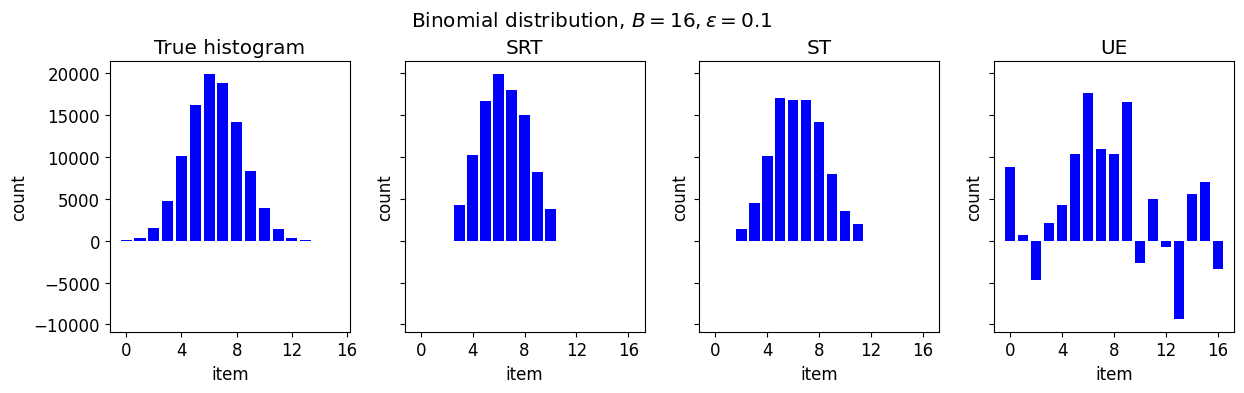

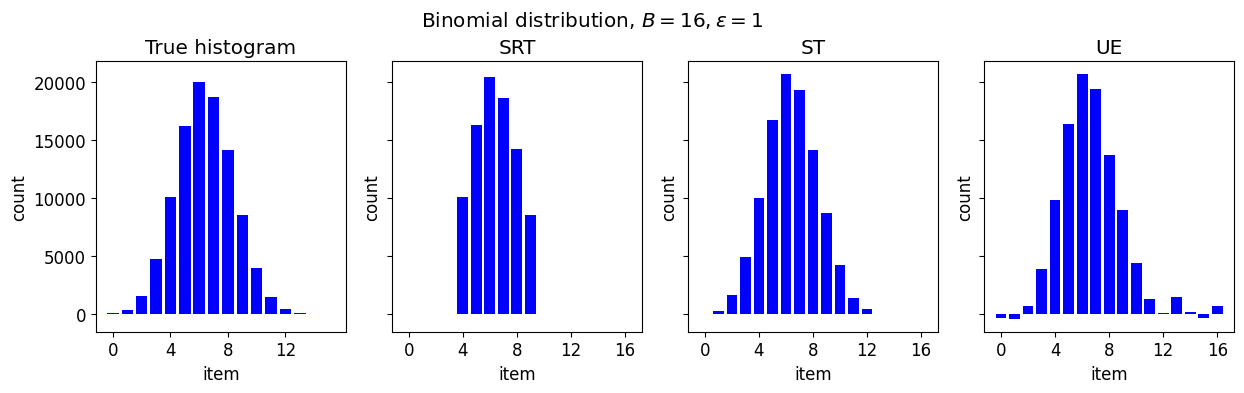

In [ ]:
#Checking dimension

import matplotlib.pyplot as plt


plt.rcParams.update({'font.size': 12})

B = 16

for i in [0]:
    cx0 = Dataset[i][0]
    calg0 = Dataset[i][1]
    calg1 = Dataset[i][2]
    calg2 = Dataset[i][3]

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12, 4))
    f.suptitle(f"Binomial distribution, $B = 256, \epsilon = {0.1}$")
    stepsize = max(1, len(calg0) // 4)

    ax1.bar(cx0.keys(), cx0.values(),  color='b')
    ax1.set_title("True histogram")
    ax1.set_xticks(range(0, len(calg0), stepsize))
    ax1.set_xlabel("item")
    ax1.set_ylabel("count")

    ax3.bar(range(len(calg0)), calg0,  color='b')
    ax3.set_title(r"ST")
    ax3.set_xticks(range(0, len(calg0), stepsize))
    ax3.set_xlabel("item")
    ax3.set_ylabel("count")

    ax4.bar(range(len(calg1)), calg1,  color='b')
    ax4.set_title(r"UE")
    ax4.set_xticks(range(0, len(calg0), stepsize))
    ax4.set_xlabel("item")
    ax4.set_ylabel("count")

    ax2.bar( range(len(calg2)), calg2,  color='b')
    ax2.set_title(r"SRT")
    ax2.set_xticks(range(0, len(calg0), stepsize))
    ax2.set_xlabel("item")
    ax2.set_ylabel("count")

    plt.tight_layout(rect=[0, 0, 1.05, 1.05])



for i in [-1]:
    cx0 = Dataset[i][0]
    calg0 = Dataset[i][1]
    calg1 = Dataset[i][2]
    calg2 = Dataset[i][3]

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12, 4))
    f.suptitle(f"Binomial distribution, $B = 256, \epsilon = {1}$")
    stepsize = max(1, len(calg0) // 4)

    ax1.bar(cx0.keys(), cx0.values(),  color='b')
    ax1.set_title("True histogram")
    ax1.set_xticks(range(0, B, stepsize))
    ax1.set_xlabel("item")
    ax1.set_ylabel("count")

    ax3.bar(range(len(calg0)), calg0,  color='b')
    ax3.set_title(r"ST")
    ax3.set_xticks(range(0, len(calg0), stepsize))
    ax3.set_xlabel("item")
    ax3.set_ylabel("count")

    ax4.bar(range(len(calg1)), calg1,  color='b')
    ax4.set_title(r"UE")
    ax4.set_xticks(range(0, len(calg0), stepsize))
    ax4.set_xlabel("item")
    ax4.set_ylabel("count")

    ax2.bar( range(len(calg2)), calg2,  color='b')
    ax2.set_title(r"SRT")
    ax2.set_xticks(range(0, len(calg0), stepsize))
    ax2.set_xlabel("item")
    ax2.set_ylabel("count")
    plt.tight_layout(rect=[0, 0, 1.05, 1.05])